# Testing Predictors of Rent Stabilized Unit Loss

# Project Overview

In February 2015, the City of New York created a new Tenant Harassment Prevention Taskforce to protect residents of rent stabilized homes. There are some 1 million rent stabilized units in the city, comprising of almost half of the rental housing stock [reference: http://furmancenter.org/research/publication/profile-of-rent-stabilized-units-and-tenants-in-new-york-city]. With the real estate market booming, city leadership was determined to take action against a small minority of landlords who engaged in predatory and illegal behavior to drive tenants out of their homes.

MODA helped the Taskforce focus inspection and enforcement resources where risk is highest, supporting a data-driven approach to standing up for tenants' rights.

## Read in data

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.options.display.float_format = '{:>,.2f}'.format

# graphics with matplot lib
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('seaborn-poster')
plt.style.use('ggplot')

import numpy as np

import gatherData as gd

In [2]:
# time period 2011-2014 (4 years)

# 311 data
complaints = gd.gather311()
complaints = gd.categorize311(complaints)

# DOF ownership data
own = gd.gatherSale()

# DOB jobs data, alt1-3, multiple floors
jobs = gd.gatherConst()

# DOB complaints
dob = gd.gatherDOBcomp()

# rent stabilized data from http://taxbills.nyc/
stab = gd.gatherRentStab()


311 initial pull (3993847, 8)
311 after dropping non positive BBLs (3974750, 8)
DOF (145759, 3)
jobs (1086357, 6)
dob complaints (446051, 42)


/usr/local/lib/python2.7/dist-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


dob illegal work (48356, 44)
rent stab (44968, 23)


## Organize and merge onto a dataframe

In [3]:
# merge sale and jobs 
saleJob = own.merge(jobs, how='inner', on='BBL')

# only keeping rows where the sales preceded the job filing
saleJob = saleJob[saleJob.DOF_OWNR_NAME_UPDTD <= saleJob.J_PRE_FILING_DATE]

# time interval is the time between the sale and job filing
saleJob['time interval'] = saleJob['J_PRE_FILING_DATE']-saleJob['DOF_OWNR_NAME_UPDTD']

# for each BBL,sale year, drop all but the shortest time interval
# then drop any duplicate job dates
saleJob = saleJob.sort_values(['BBL','time interval'])\
                .drop_duplicates(['saleYear','BBL'])\
                .drop_duplicates(['J_PRE_FILING_DATE','BBL'])

print 'sale and job', saleJob.shape

sale and job (13539, 9)


In [4]:
# Merge all onto rent stabilized dataframe

compTypes = complaints.ComplaintType.unique()
complaintByBBLYear = complaints.groupby(['BBL',
                                         'ComplaintType',
                                         'YEAR_DT']).count()[['COUNT']].reset_index()

for year in range(2011,2015):
    for types in compTypes:
        col = str(year)+" 311SR " +types
        stab[col] = stab.merge(complaintByBBLYear[(complaintByBBLYear.YEAR_DT==year) &
                            (complaintByBBLYear.ComplaintType==types)],
                               how='left',left_on='ucbbl',right_on='BBL').COUNT

# sales and sales/constr
for year in range(2011,2015):
    # sales data
    stab[str(year)+" Sale"] = 0 #initialize column
    stab.loc[stab.ucbbl.isin(own[own.saleYear==year].BBL),
             str(year)+' Sale'] = 1 #flag if bbl has been sold in that year
    # same for sales/construction data
    stab[str(year)+" Sale+Construction"] = 0 
    stab.loc[stab.ucbbl.isin(saleJob[saleJob.saleYear==year].BBL),
             str(year)+' Sale+Construction'] = 1 #flag if bbl has sale then job

# dob complaints
for year in range(2011,2015):
    stab[str(year)+' DOB Illegal Work'] = 0 #initialize column
    stab.loc[stab.ucbbl.isin(dob[dob.DOBYear==year].BBL),
             # flag if bbl had a DOB complaint that year
             str(year)+' DOB Illegal Work'] = 1
    
stab.head()

,ucbbl,2007uc,2008uc,2009uc,2010uc,2011uc,2012uc,2013uc,2014uc,2008loss,2009loss,2010loss,2011loss,2012loss,2013loss,2014loss,2008losspct,2009losspct,2010losspct,2011losspct,2012losspct,2013losspct,2014losspct,2011 311SR HPD - No Services,2011 311SR NA,2011 311SR Other,2011 311SR Dirty Conditions,2011 311SR HPD,2011 311SR Construction,2011 311SR DOB Illegal Work,2011 311SR Air Quality - NonConstruction,2011 311SR DOB,2011 311SR Hazardous Materials,2011 311SR Asbestos,2011 311SR Dust - Construction DEP,2011 311SR Dust - Construction DOHMH,2012 311SR HPD - No Services,2012 311SR NA,2012 311SR Other,2012 311SR Dirty Conditions,2012 311SR HPD,2012 311SR Construction,2012 311SR DOB Illegal Work,2012 311SR Air Quality - NonConstruction,2012 311SR DOB,2012 311SR Hazardous Materials,2012 311SR Asbestos,2012 311SR Dust - Construction DEP,2012 311SR Dust - Construction DOHMH,2013 311SR HPD - No Services,2013 311SR NA,2013 311SR Other,2013 311SR Dirty Conditions,2013 311SR HPD,2013 311SR Construction,2013 311SR DOB Illegal Work,2013 311SR Air Quality - NonConstruction,2013 311SR DOB,2013 311SR Hazardous Materials,2013 311SR Asbestos,2013 311SR Dust - Construction DEP,2013 311SR Dust - Construction DOHMH,2014 311SR HPD - No Services,2014 311SR NA,2014 311SR Other,2014 311SR Dirty Conditions,2014 311SR HPD,2014 311SR Construction,2014 311SR DOB Illegal Work,2014 311SR Air Quality - NonConstruction,2014 311SR DOB,2014 311SR Hazardous Materials,2014 311SR Asbestos,2014 311SR Dust - Construction DEP,2014 311SR Dust - Construction DOHMH,2011 Sale,2011 Sale+Construction,2012 Sale,2012 Sale+Construction,2013 Sale,2013 Sale+Construction,2014 Sale,2014 Sale+Construction,2011 DOB Illegal Work,2012 DOB Illegal Work,2013 DOB Illegal Work,2014 DOB Illegal Work
0,1000077501,21.00,17.00,16.00,13.00,9.00,9.00,9.00,9.00,4.00,1.00,3.00,4.00,0.00,0.00,0.00,19.05,5.88,18.75,30.77,0.00,0.00,0.00,1.00,5.00,3.00,1.00,nan,nan,nan,nan,1.00,nan,nan,nan,nan,nan,8.00,4.00,2.00,nan,nan,nan,1.00,1.00,nan,nan,nan,nan,nan,4.00,7.00,1.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,3.00,4.00,2.00,nan,1.00,1.00,1.00,2.00,1.00,nan,nan,nan,0,0,0,0,0,0,0,0,0,0,0,0
1,1000150022,6.00,5.00,5.00,2.00,2.00,1.00,7.00,5.00,1.00,0.00,3.00,0.00,1.00,-6.00,2.00,16.67,0.00,60.00,0.00,50.00,-600.00,28.57,nan,9.00,4.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,9.00,3.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,12.00,3.00,3.00,1.00,1.00,nan,nan,nan,nan,nan,nan,nan,nan,6.00,9.00,nan,nan,1.00,nan,nan,nan,nan,nan,nan,nan,0,0,0,0,0,0,0,0,0,0,0,0
2,1000160015,208.00,208.00,208.00,208.00,208.00,208.00,208.00,208.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan,8.00,2.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,4.00,6.00,nan,1.00,1.00,nan,nan,nan,nan,nan,nan,nan,nan,8.00,4.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,5.00,7.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,0,0,0,0,0,0,0,0,0,0,0
3,1000160020,209.00,209.00,209.00,209.00,209.00,209.00,209.00,209.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan,6.00,11.00,nan,nan,2.00,1.00,nan,nan,nan,nan,nan,nan,nan,7.00,6.00,nan,nan,2.00,nan,nan,nan,nan,nan,nan,nan,nan,8.00,12.00,nan,nan,2.00,nan,nan,nan,nan,nan,nan,nan,nan,4.00,6.00,1.00,nan,1.00,nan,nan,nan,nan,nan,nan,nan,0,0,0,0,0,0,0,0,0,0,0,0
4,1000160180,293.00,293.00,292.00,293.00,293.00,293.00,293.00,293.00,0.00,1.00,-1.00,0.00,0.00,0.00,0.00,0.00,0.34,-0.34,0.00,0.00,0.00,0.00,nan,5.00,2.00,nan,nan,1.00,nan,nan,nan,1.00,nan,nan,nan,nan,10.00,4.00,nan,nan,nan,nan,nan,1.00,nan,nan,nan,nan,nan,5.00,1.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,6.00,3.00,nan,nan,1.00,nan,nan,nan,1.00,nan,nan,nan,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
stab.sum()[1:16]

2007uc     909,363.00
2008uc     895,304.00
2009uc     844,786.00
2010uc     844,714.00
2011uc     859,776.00
2012uc     874,107.00
2013uc     874,306.00
2014uc     861,842.00
2008loss    14,059.00
2009loss    17,520.00
2010loss     7,364.00
2011loss     3,769.00
2012loss    -2,380.00
2013loss     8,785.00
2014loss     4,819.00
dtype: float64

In [6]:
stab.filter(like='2014').sum()[-16:]

2014 311SR HPD - No Services                61,675.00
2014 311SR NA                               28,374.00
2014 311SR Other                            84,217.00
2014 311SR Dirty Conditions                 11,693.00
2014 311SR HPD                             154,589.00
2014 311SR Construction                      4,492.00
2014 311SR DOB Illegal Work                  5,484.00
2014 311SR Air Quality - NonConstruction     1,078.00
2014 311SR DOB                               8,057.00
2014 311SR Hazardous Materials                 405.00
2014 311SR Asbestos                            639.00
2014 311SR Dust - Construction DEP             356.00
2014 311SR Dust - Construction DOHMH           345.00
2014 Sale                                    2,832.00
2014 Sale+Construction                         717.00
2014 DOB Illegal Work                        1,454.00
dtype: float64

## Method - Predictors of RS Unit Loss

The average probability that a building experiences unit loss can be estimated by dividing the number of buildings which experienced loss by the total number of rent stabilized buildings.

$$ P(loss) = \frac{n(loss>threshold)}{n}  $$

This is an average, irrespective of any conditions present in the building. We can identify certain conditions (or predictors) to test if they are more or less predictive of unit loss. 

$$ P(loss\ |\ predictor) = \frac{n(loss>threshold\ AND\ predictor=1)}{n(predictor=1)}$$

The ratio of these is called the Risk Ratio (RR).

$$ RR(predictor) = \frac{P(loss\ |\ predictor)}{P(loss)} $$

If the RR is greater than 1 then a building with the predictor present is that many times more likely to experience unit loss than a randomly chosen building. This is what we'll use to test if the predictors are related to unit loss.

Because we are using DOF data on rent stabilization, we don't have building identifiers but we have something almost as good: BBL's. BBL is the DOF unique identifier for a tax lot. Sometimes there is more than one building per lot, so we are actually estimating the probability of a lot (BBL) losing units. 

In the riskratio function below we calculate RR from the stab dataframe. The stab dataframe has data from 2012-2014, so in order to get the most out of this, we are going to average over all BBL-years. This means that each BBL is counted separately for each year, eg. BBL=1000000001 in 2012 is seen as a different BBL from BBL=1000000001 in 2013. 

In [7]:
# list of predictors to test
# used in riskratio function below
pred = complaints.ComplaintType.unique()
pred = ['311SR '+ x for x in pred ]
# adding on the non-311 predictors
pred.append('Sale')
pred.append('Sale+Construction')
pred.append('DOB Illegal Work')
print '\n'.join(pred)


def riskratio(data,losstype='loss',lbound=0,yr=0):
    '''
    risk ratio is the prob of unit loss given the presence of a predictor 
        divided by the prob of unit loss in general.
    
    data = dataframe where rows are unique bbls and
        columns are unit counts, unit loss, and predictors by year
    losstype = 'loss'(if lower bound is a count) 
        or 'losspct'(if lower bound is percent)
    lbound = lower bound on number of units lost, int>=0
    yr=0 for  complaints in current year, yr=1 for complaints in previous year
    returns risk ratio and the number of buildings with loss and a predictor present 
    '''
    # numerator and denominator - prob of loss given predictors present
    # each row is a predictor type and each column is a year
    numerator = pd.DataFrame(index=pred)
    denominator = pd.DataFrame(index=pred)
    
    # time range to average over
    yrRange = range(2012,2015)
    
    # baseline probability of loss - index is year
    # built up of a base numerator and base denominator
    baseProb = pd.DataFrame(index=[str(year) for year in yrRange])
    basenum = []
    baseden = []
    
    #do each year separately and then sum over later
    for year in yrRange:
        probloss = []
        numberloss = []
        numberbbls = []
        
        # set up base prob : basenum and baseden
        # number of base BBL's
        basedf = data[(data[str(year-1)+'uc']>0)&   # has units in prev year
                      (data[str(year)  +'uc']>=0)]  # and current year is not null
        bblsbase = basedf.shape[0]
        baseden.append(bblsbase)
        
        # bbls with loss
        lossbase = basedf[basedf[str(year)+losstype]>=lbound].shape[0] 
        basenum.append(lossbase)
    

        for prd in pred:       
            # number of bbls with predictors present
            # starting with the basedf from above
            # pick out the ones with predictors prd
            df = basedf[basedf[str(year-yr)+" "+prd]>0] 
            bbls = df.shape[0] # number of bbls is number of rows

            # of those, number of bbls with unit loss in current year
            bblswithloss = df[df[str(year)+losstype]>=lbound].shape[0] 

            # prob is the ratio of the above, save both separately
            numberloss.append(bblswithloss)
            numberbbls.append(bbls)
        
        numerator[str(year)] = numberloss
        denominator[str(year)] = numberbbls
    
    # base prob - include a row that is the sum over years
    baseProb['numerator'] = basenum
    baseProb['denominator'] = baseden
    baseProb.loc['2012-2014'] = baseProb[baseProb.index.astype(int)>2011].sum()
    baseProb['prob']=baseProb['numerator']/baseProb['denominator']
    
    #average the three years together and then take the ratio
    numerator['2012-2014'] = numerator[['2012','2013','2014']].sum(axis=1)
    denominator['2012-2014'] = denominator[['2012','2013','2014']].sum(axis=1)
    probLossPred = numerator/denominator
    
    ratio = probLossPred.div(baseProb['prob'])
    avgRatio = ratio['2012-2014']

    return avgRatio, numerator
    

311SR HPD - No Services
311SR NA
311SR Other
311SR Dirty Conditions
311SR HPD
311SR Construction
311SR DOB Illegal Work
311SR Air Quality - NonConstruction
311SR DOB
311SR Hazardous Materials
311SR Asbestos
311SR Dust - Construction DEP
311SR Dust - Construction DOHMH
Sale
Sale+Construction
DOB Illegal Work


If we set the threshold lower bound on unit loss to 5 units, we got the following. Dust and Asbestos complaints come out at the top of the list. 

In [10]:
(ratio,num) = riskratio(stab,lbound=5)
ratio.sort_values(ascending=False)

311SR Dust - Construction DEP         4.54
311SR Asbestos                        4.10
311SR Air Quality - NonConstruction   3.35
311SR Construction                    3.27
311SR Hazardous Materials             3.27
311SR Dust - Construction DOHMH       2.69
DOB Illegal Work                      2.57
Sale+Construction                     2.47
311SR DOB                             2.26
311SR DOB Illegal Work                2.16
311SR NA                              1.71
311SR Dirty Conditions                1.67
311SR HPD                             1.46
311SR HPD - No Services               1.32
311SR Other                           1.30
Sale                                  1.28
Name: 2012-2014, dtype: float64

Even though we have averaged over three years, do we have enough data points to conclusively say something? The second part of the riskration function returns the number of BBLs that experienced unit loss and the associated predictor. If this number is too low, that's an indication that we shouldn't place too much confidence in the accuracy of the RR. 

In [11]:
num

,2012,2013,2014,2012-2014
311SR HPD - No Services,261,325,231,817
311SR NA,246,291,239,776
311SR Other,390,509,315,1214
311SR Dirty Conditions,138,170,126,434
311SR HPD,247,335,220,802
311SR Construction,95,117,120,332
311SR DOB Illegal Work,108,104,84,296
311SR Air Quality - NonConstruction,41,50,38,129
311SR DOB,183,164,122,469
311SR Hazardous Materials,9,14,20,43


It's not too bad. But a better way of understanding this is to apply confidence intervals to the RR. This allows us to see a band around which we can reasonably assume the RR lies within. When we have large numbers of data points the band gets smaller, or more accurate. When we only have a small amount of data the band becomes larger and less accurate. 

We will use the bootstrap method to determine the confidence intervals. The idea is that if the data we have is a reasonable sample of the population in general, we can treat it as if it is the full population and then pull sub-samples from it. This is called sampling with replacement (e.g. if our data is (2,6,4) possible sub-samples are (2,2,4) or (6,4,4) or (4,6,2)). We treat the sub-samples as if they are independent trials. Any estimator, in this case the risk ratio, is calculated and the bottom 5th percentile and top 95th percentile will make up the confidence interval.

In order to do this we are using the resample function from the scikit-learn package.

In [12]:
from sklearn.utils import resample

In [13]:
# bootstrap to find confidence intervals:
# create a data frame, called samples, 
# each column is the results after sampling with
# with replacement from the original stab datafram

samples = pd.DataFrame()
for i in range(1000):
    (samples[i],n) = riskratio(resample(stab),lbound=5)

In [14]:
# taking the 5th percentile from all the samples for a lower bound
samples.quantile(.05, axis =  1).sort_values()

Sale                                  1.10
311SR HPD - No Services               1.27
311SR Other                           1.28
311SR HPD                             1.40
311SR Dirty Conditions                1.56
311SR NA                              1.63
311SR Dust - Construction DOHMH       1.90
311SR DOB Illegal Work                1.97
Sale+Construction                     1.97
311SR DOB                             2.11
DOB Illegal Work                      2.18
311SR Hazardous Materials             2.40
311SR Air Quality - NonConstruction   2.87
311SR Construction                    3.01
311SR Asbestos                        3.29
311SR Dust - Construction DEP         3.39
Name: 0.05, dtype: float64

In [15]:
# 95th percentile from all the samples for an upper bound
samples.quantile(.95, axis =  1).sort_values()

311SR Other                           1.33
311SR HPD - No Services               1.37
Sale                                  1.49
311SR HPD                             1.52
311SR NA                              1.78
311SR Dirty Conditions                1.79
311SR DOB Illegal Work                2.34
311SR DOB                             2.42
DOB Illegal Work                      2.95
Sale+Construction                     3.05
311SR Dust - Construction DOHMH       3.52
311SR Construction                    3.56
311SR Air Quality - NonConstruction   3.89
311SR Hazardous Materials             4.21
311SR Asbestos                        4.89
311SR Dust - Construction DEP         5.70
Name: 0.95, dtype: float64

After putting this all together and wrapping it up with a graph, we see that the predictors with the most numbers also have the shortest confidence intervals: "311 Other" and vice versa: "311SR Dust".

In [16]:
def plotRR(data,losstype='loss',lbound=0,yr=0,trials=1000):
    
    (ratio,num) = riskratio(data=data,losstype=losstype,lbound=lbound,yr=yr)
    samples = pd.DataFrame()
    for i in range(trials):
        (samples[i],n) = riskratio(data=resample(data),
                                   losstype=losstype,lbound=lbound,yr=yr)
    
    units = '+ units ' if losstype=='loss' else '% + units '
    predyear = 'in the same year,\n' if yr==0 else 'in the previous year,\n'

    title='Risk Ratio: Probability of loosing '+str(lbound)+units+\
    '\n if predictor was present '+ predyear +\
    'Compared to baseline probability of any bbl loosing units'

    # error bars
    errmax = samples.quantile(.95, axis =  1) - ratio
    errmin = ratio - samples.quantile(.05, axis =  1)
    error = [[errmin,errmax]]
    #print resample(data)
    #print samples
    #print errmax
    ratio.plot(kind='barh',xerr=error,
               figsize=(10,7),title=title,color='lightblue')
    plt.axvline(1, color ='grey', linewidth=5,alpha=.6)
    

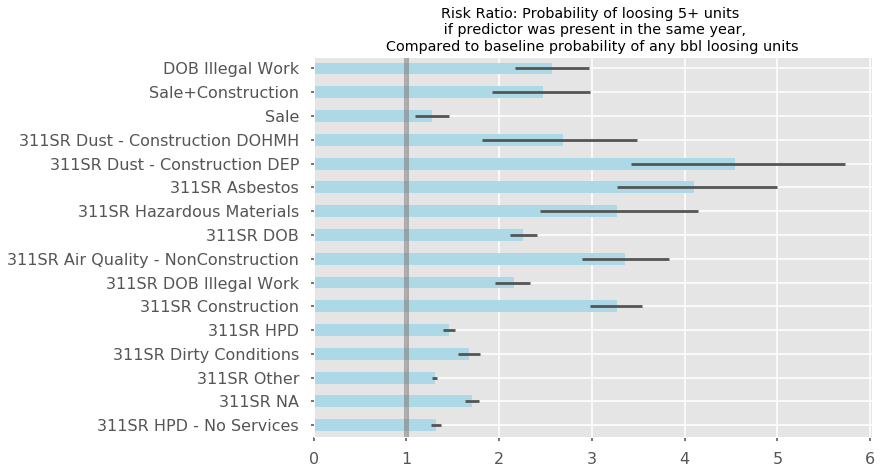

In [17]:
plotRR(data=stab,lbound=5,trials=1000)

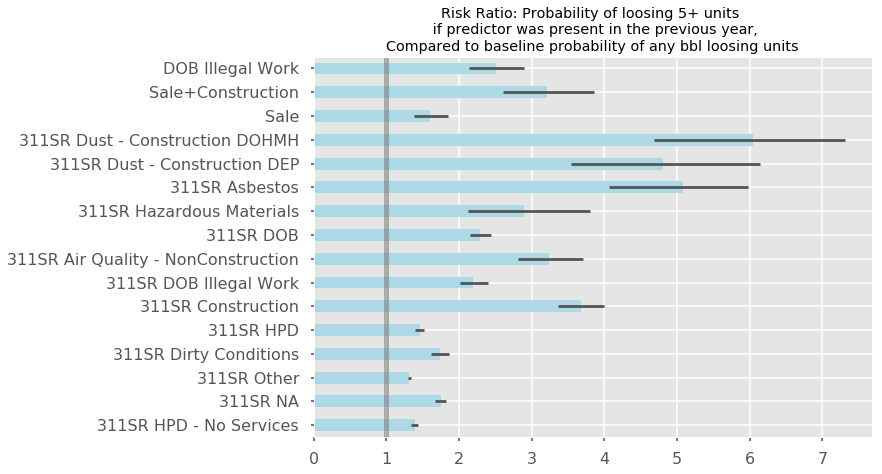

In [18]:
plotRR(data=stab,lbound=5,yr=1,trials=1000)

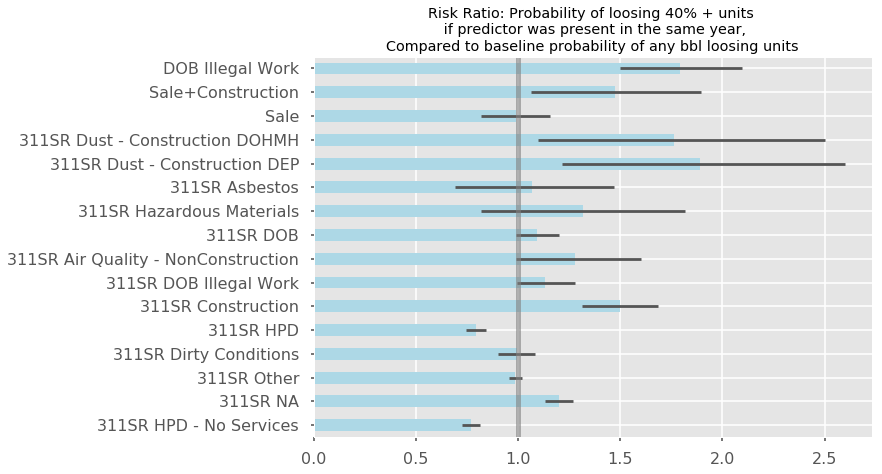

In [19]:
plotRR(data=stab,losstype='losspct',lbound=40,yr=0,trials=1000)

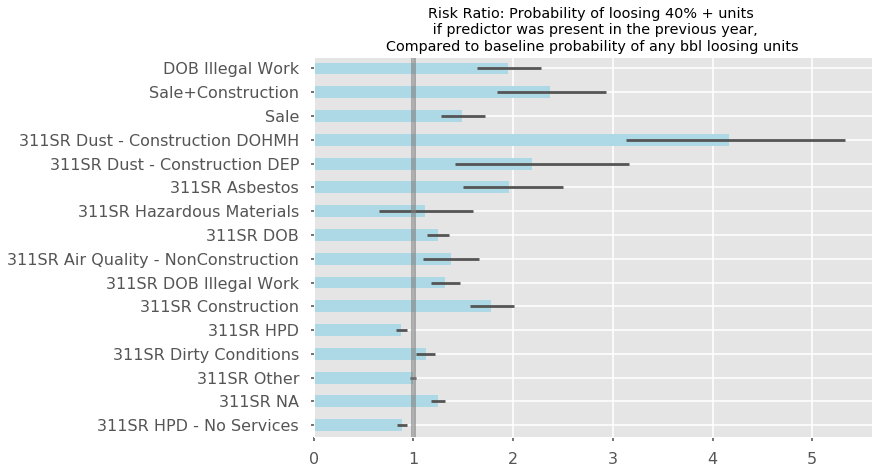

In [20]:
plotRR(data=stab,losstype='losspct',lbound=40,yr=1,trials=1000)

## Results
The first two graphs above use loss to mean that 5 or more units were lost in the BBL. The second two graphs define loss as 40% or more of units in the BBL. 
The second and fourth graphs constrain the unit loss to happen the year after the presence of the predictor is observed. 
In all four graphs the same predictors pop up as the most relevant: DOB illegal work, Sale+Construction, Dust, Asbestos, and 311 construction.

Surprisingly HPD No Services complaints (these are complaints about landlords not providing heat and hot water among other things) are not very predictive of unit loss. This is likely because there are so many of these complaints, from tenants of all buildings. Choosing buildings with HPD No Services complaints is not that different from choosing a rent stabilized building at random. 